In [1]:
import numpy as np 
from numpy.random import seed

import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from tqdm import tqdm
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import metrics

2022-04-08 10:55:23.946878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 10:55:23.946979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
training_binary = np.load("/home/ninju/Desktop/dl/project/japanese/k49-train-imgs.npz")
label_binary = np.load("/home/ninju/Desktop/dl/project/japanese/k49-train-labels.npz")
print(training_binary.files, label_binary.files)

['arr_0'] ['arr_0']


In [3]:
Xtrain = training_binary["arr_0"]
ytrain = label_binary["arr_0"]
print("Xshape:", Xtrain.shape)
print("yshape:", ytrain.shape)
num_class = len(np.unique(ytrain))
print("Classes:", num_class)
img_dim = Xtrain.shape[1]
print(ytrain[0:10])

Xshape: (232365, 28, 28)
yshape: (232365,)
Classes: 49
[30 19 20 30  7  4 35 20 24 43]


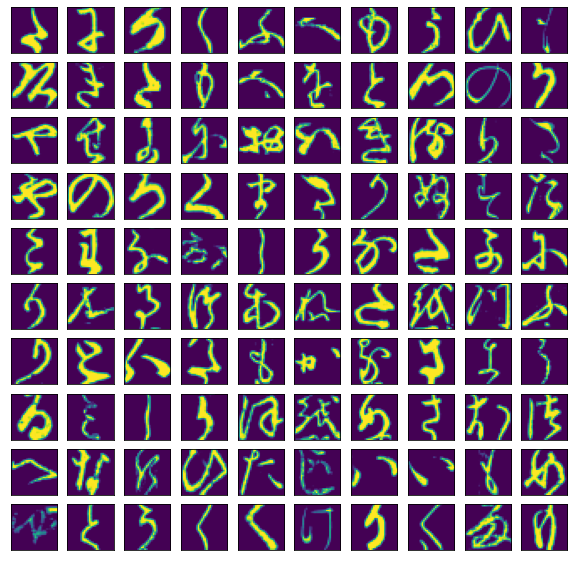

In [4]:
def showRandom100Examples(X, y, imgdim=28):
    random_idx = np.random.randint(0, X.shape[0], 100)
    random_set = X[random_idx]
    random_set = random_set.reshape(10, 10, imgdim, imgdim)
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(random_set.shape[0]):
        for j in range(random_set.shape[1]):
            example = random_set[i, j]
            ax[i, j].imshow(example)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.show()
            
showRandom100Examples(Xtrain, 0)

In [5]:
Xtrain = Xtrain.reshape(-1, 28*28)
print("Training set shape:", Xtrain.shape)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)

ecd = OneHotEncoder()
ecd.fit(ytrain.reshape(-1, 1))
ytrain = ecd.transform(ytrain.reshape(-1, 1)).toarray()
print(ytrain[0:10])

Training set shape: (232365, 784)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [6]:
def buildModel(dropout_rate = 0.0, num_hidden = 3, hidden_size = 512):
    model = Sequential()
    model.add(InputLayer(input_shape=(img_dim**2,)))

    for i in range(num_hidden):
        model.add(Dense(hidden_size, activation = 'relu'))
        model.add(Dropout(dropout_rate, input_shape = (hidden_size,)))

    model.add(Dense(num_class, activation = 'softmax'))
    model.compile(loss = categorical_crossentropy, optimizer = Adam(1e-4), metrics = ['accuracy'])
    return model


model = buildModel(dropout_rate = 0.3, num_hidden = 4, hidden_size = 512)
earlystop = EarlyStopping(monitor = "val_loss", min_delta = 1e-3, mode = "min",patience = 2)

model.fit(Xtrain, ytrain, epochs=5, validation_split=0.2)

print("Training completed")

2022-04-08 11:06:58.414174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 11:06:58.437076: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 11:06:58.480403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hp-240-g7-notebook-pc): /proc/driver/nvidia/version does not exist
2022-04-08 11:06:59.634541: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 11:07:11.538994: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58295

Epoch 1/5
5810/5810 [==============================] - ETA: 0s - loss: 1.6629 - accuracy: 0.5618

2022-04-08 11:08:55.154388: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145739328 exceeds 10% of free system memory.


5810/5810 [==============================] - 91s 13ms/step - loss: 1.6629 - accuracy: 0.5618 - val_loss: 0.8192 - val_accuracy: 0.7796
Epoch 2/5
5810/5810 [==============================] - 73s 12ms/step - loss: 0.9706 - accuracy: 0.7347 - val_loss: 0.6087 - val_accuracy: 0.8336
Epoch 3/5
5810/5810 [==============================] - 73s 13ms/step - loss: 0.7916 - accuracy: 0.7810 - val_loss: 0.5122 - val_accuracy: 0.8585
Epoch 4/5
5810/5810 [==============================] - 74s 13ms/step - loss: 0.6912 - accuracy: 0.8085 - val_loss: 0.4595 - val_accuracy: 0.8711
Epoch 5/5
5810/5810 [==============================] - 75s 13ms/step - loss: 0.6218 - accuracy: 0.8256 - val_loss: 0.4164 - val_accuracy: 0.8831
Training completed


In [7]:
test_data_bin = np.load("/home/ninju/Desktop/dl/project/japanese/k49-test-imgs.npz")
test_labels_bin = np.load("/home/ninju/Desktop/dl/project/japanese/k49-test-labels.npz")

Xtest = test_data_bin["arr_0"]
ytest = test_labels_bin["arr_0"]
print("Xshape:", Xtest.shape)
print("yshape:", ytest.shape)

Xtest = Xtest.reshape(-1, 28*28)
Xtest = scaler.transform(Xtest)
ytest = ecd.transform(ytest.reshape(-1, 1)).toarray()
print("Xshape (flatten):", Xtest.shape)
print("yshape (flatten):", ytest.shape)

Xshape: (38547, 28, 28)
yshape: (38547,)
Xshape (flatten): (38547, 784)
yshape (flatten): (38547, 49)


In [8]:
model.evaluate(Xtest, ytest)

2022-04-08 11:17:53.962853: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120883392 exceeds 10% of free system memory.


1205/1205 [==============================] - 3s 3ms/step - loss: 0.7068 - accuracy: 0.8061


[0.7067628502845764, 0.8061327934265137]

In [9]:
prefix = ('', 'k', 's', 't', 'n', 'h', 'm')
suffix = ('a', 'i', 'u', 'e', 'o')
hiramap = np.array([[p+s for s in suffix] for p in prefix])
hiramap = np.append(hiramap, ['ya', 'yu', 'yo', 'ra', 'ri', 'ru', 're', 'ro', 'wa', 'wi', 'we', 'wo', 'n', 'grave'])
hiramap = np.array(hiramap).ravel()

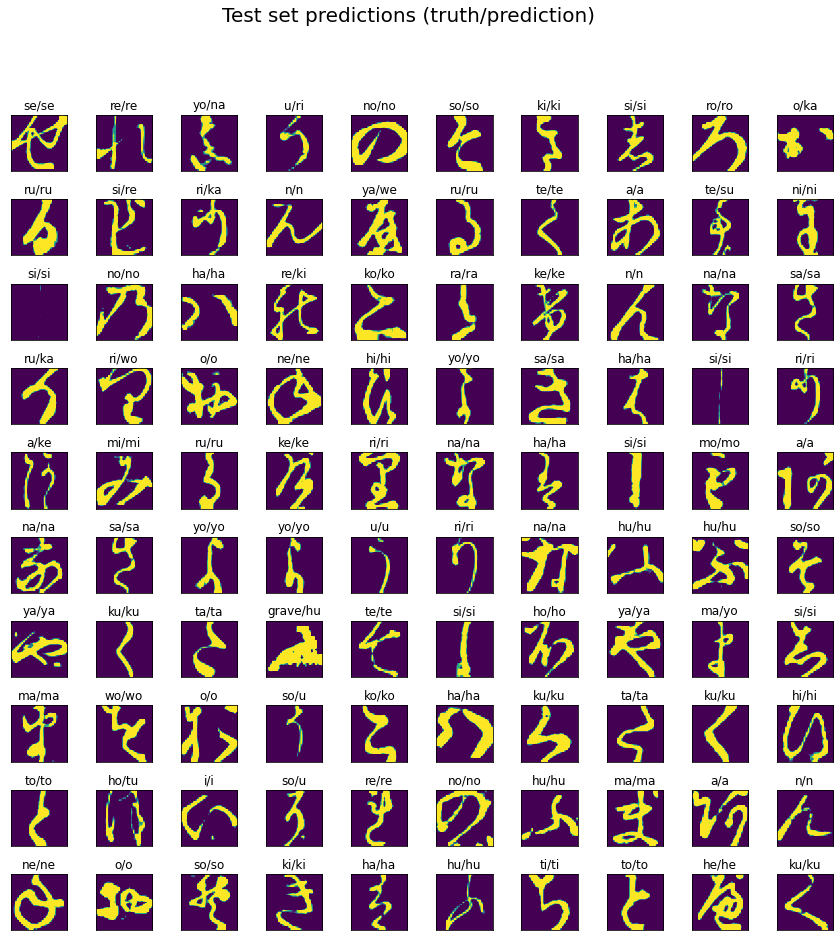

In [10]:
imgdim = 28
random_idx = np.random.randint(0, Xtest.shape[0], 100)

random_set = Xtest[random_idx]
random_labels = ecd.inverse_transform(ytest[random_idx]).reshape(10, 10)
pred_labels = model.predict(random_set).argmax(axis = 1).reshape(10, 10)

random_set = random_set.reshape(10, 10, imgdim, imgdim)

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('Test set predictions (truth/prediction)', fontsize = 20)

for i in range(random_set.shape[0]):
    for j in range(random_set.shape[1]):
        example = random_set[i, j]
        ax[i, j].imshow(example, vmin = 0, vmax = 1)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f"{hiramap[random_labels[i, j]]}/{hiramap[pred_labels[i, j]]}")

plt.subplots_adjust(hspace=0.5)
plt.show()